# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
scriptpath    = os.path.dirname(os.path.realpath( "xxxx" ))
caffe_root    = os.path.sep.join(scriptpath.split(os.path.sep)[:-1])
caffe_root = "/home/maheriya/Projects/caffe-ssd"
print("Caffe_root: {}".format(caffe_root))

Caffe_root: /home/maheriya/Projects/caffe-ssd


* Load LabelMap.

In [2]:
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/DVIADETDB/labelmap_dviadetdb.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [10]:
#model_def = 'models/VGGNet/VOC0712/SSD_300x300/deploy.prototxt'
#model_weights = 'models/VGGNet/VOC0712/SSD_300x300/VGG_VOC0712_SSD_300x300_iter_60000.caffemodel'
#model_def = 'models/ZFNet/VOC0712/SSD_300x300/deploy.prototxt'
#model_weights = 'models/ZFNet/VOC0712/SSD_300x300/ZF_VOC0712_SSD_300x300_iter_100000.caffemodel'

imsize = 150
net = "ALEX" #"ZF"
db  = "DVIADETDB"
#ver = ".2016Nov16.mark1"  # This is with image min size = 300
ver = "" #".2016Nov18.mark1"    # This is with image min size = 150
itr   = 80000
model_def     = 'models/{net}Net/{db}/SSD_{size}x{size}{v}/deploy.prototxt'.format(v=ver, db=db, net=net, size=imsize)
model_weights = 'models/{net}Net/{db}/SSD_{size}x{size}{v}/{net}_{db}_SSD_{size}x{size}_iter_{i}.caffemodel'.format(v=ver, db=db, net=net, i=itr, size=imsize)
print "model_def: {}".format(model_def)
print "model_weights: {}".format(model_weights)

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

nparams = sum([ (reduce(lambda x,y: x*y, p.data.shape)) for k in net.params for i,p in enumerate(net.params[k]) ])
print "Number of parameters: {}".format(nparams)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

model_def: models/ALEXNet/DVIADETDB/SSD_150x150/deploy.prototxt
model_weights: models/ALEXNet/DVIADETDB/SSD_150x150/ALEX_DVIADETDB_SSD_150x150_iter_80000.caffemodel
Number of parameters: 5631704


### 2. SSD detection

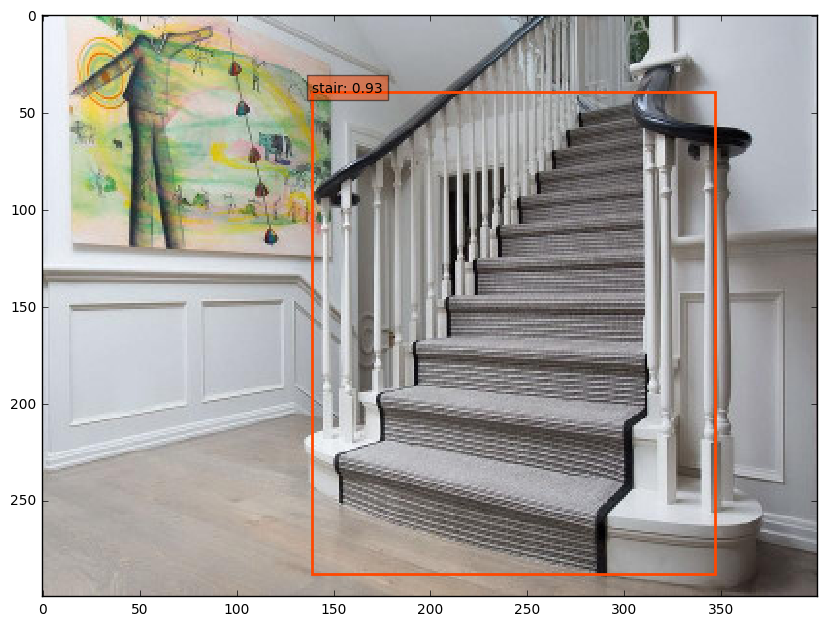

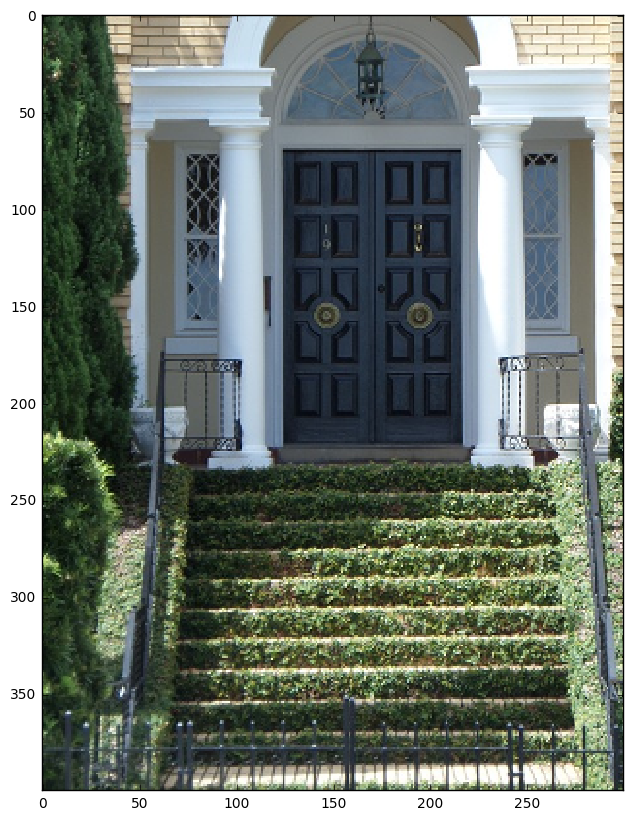

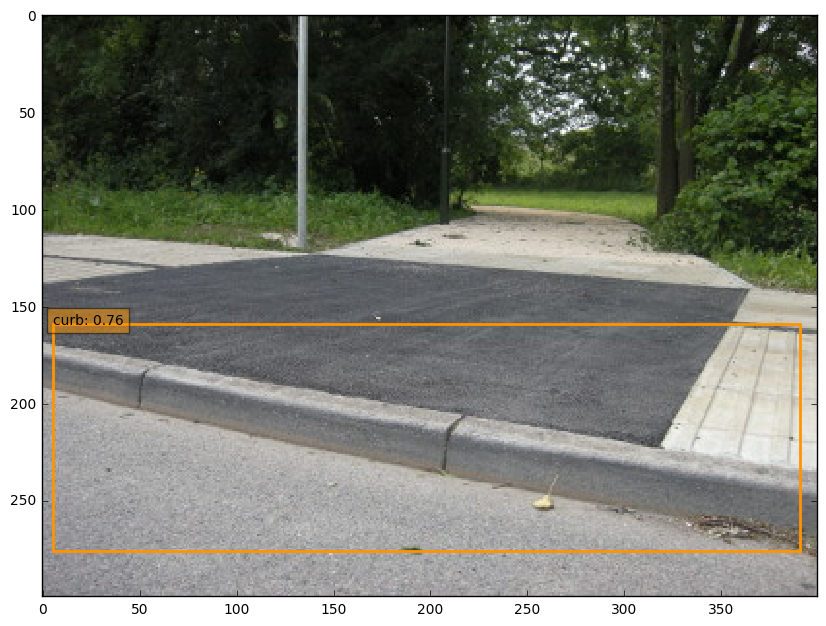

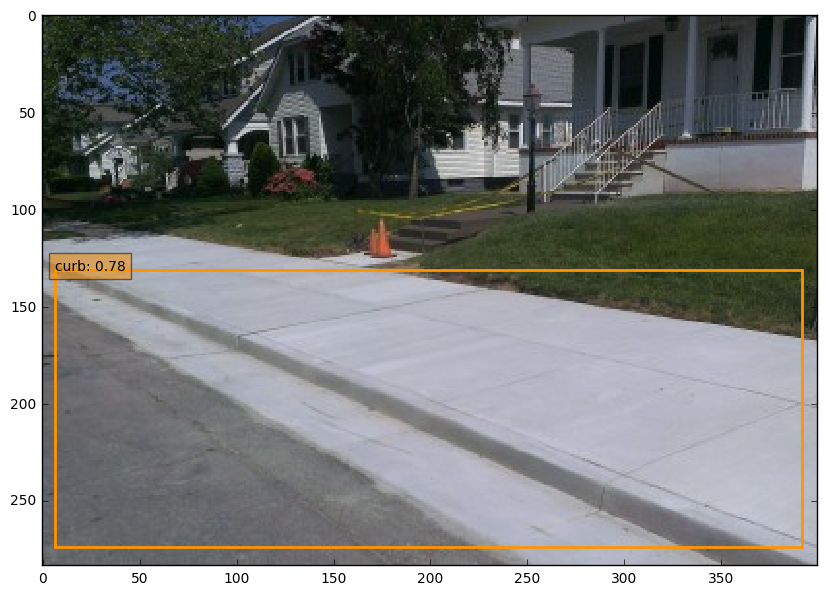

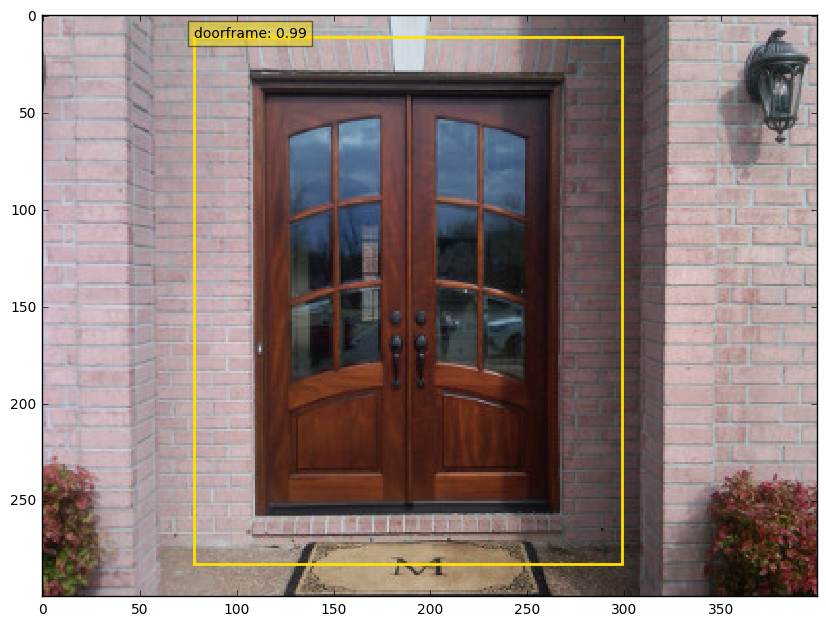

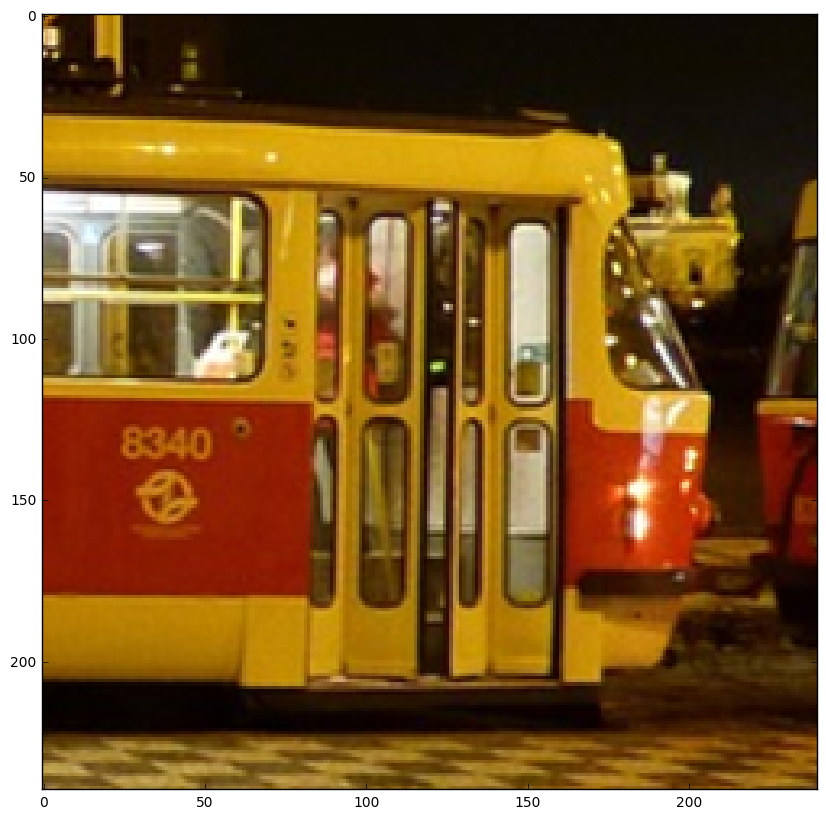

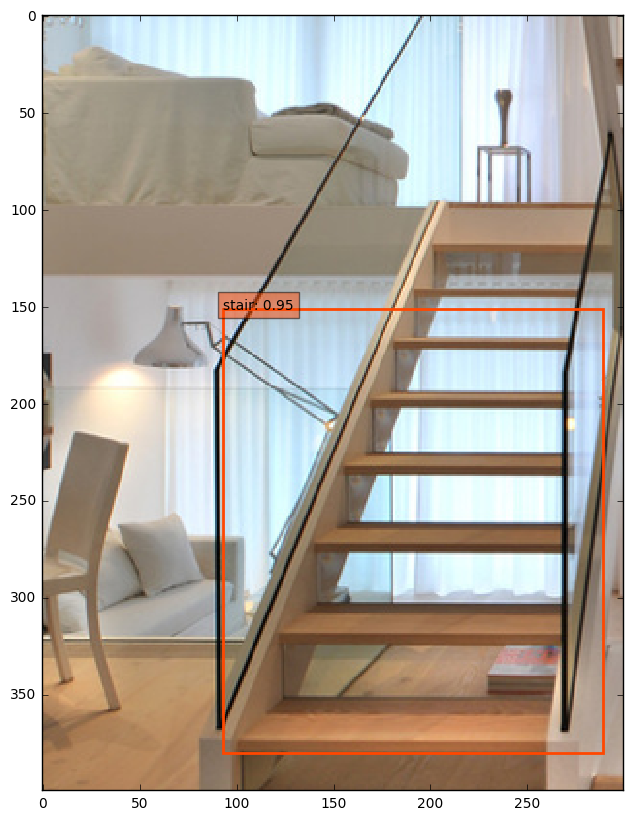

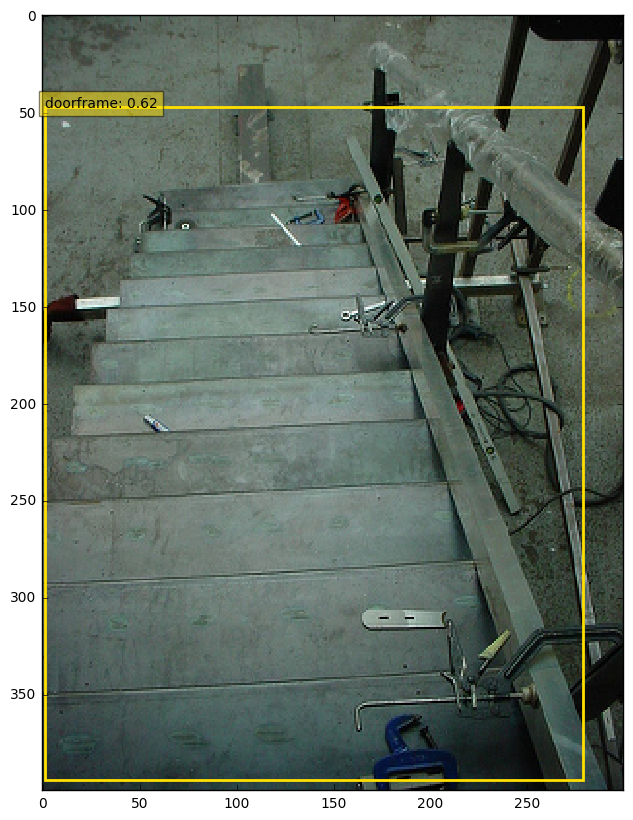

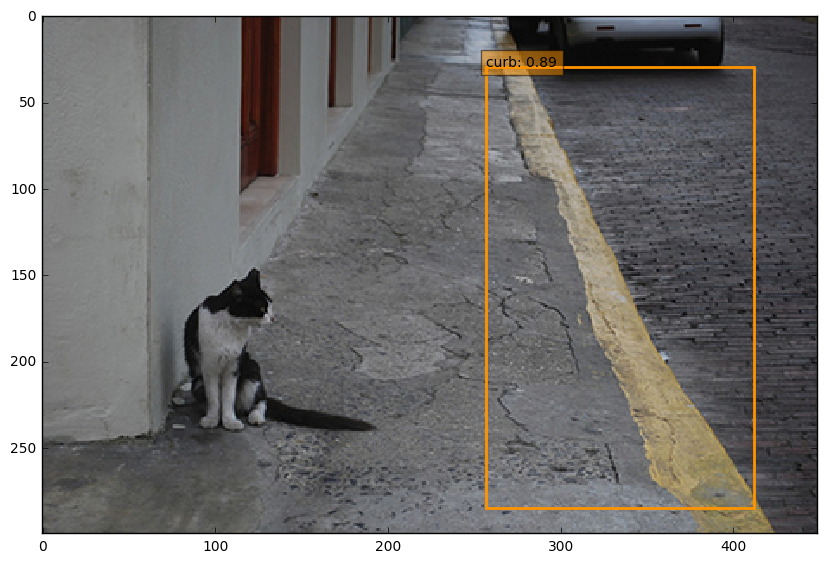

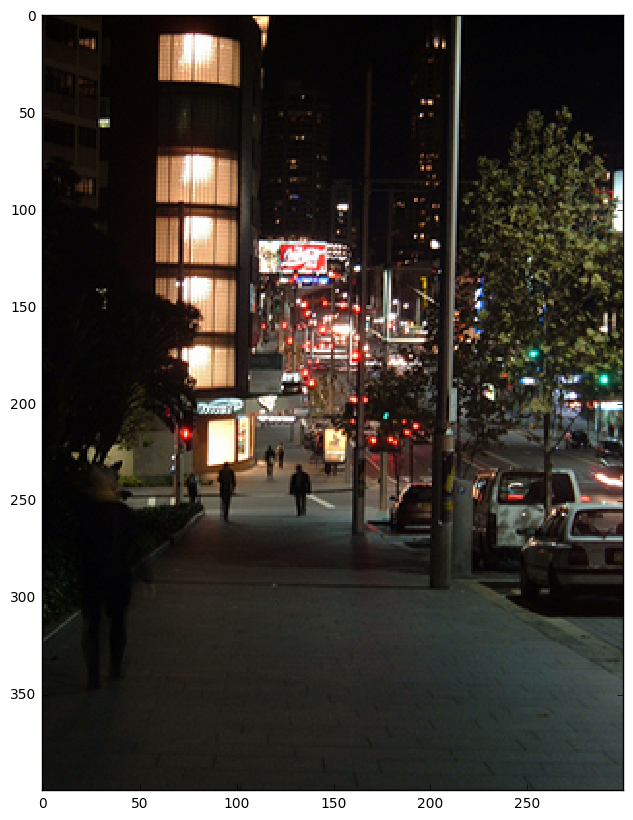

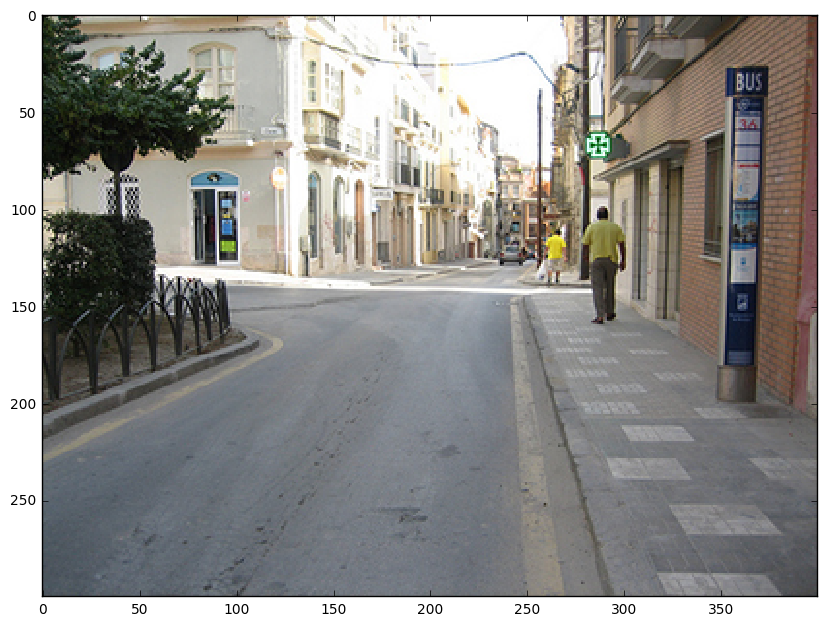

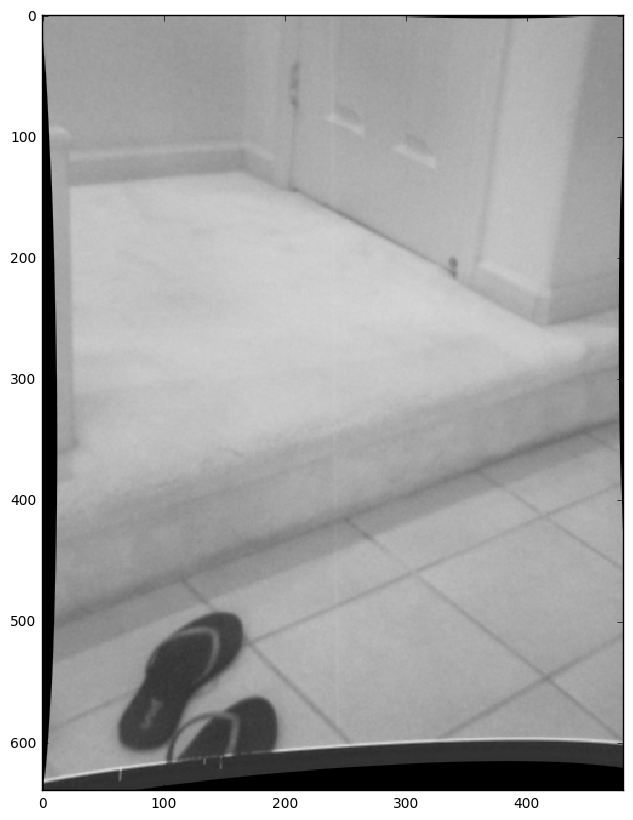

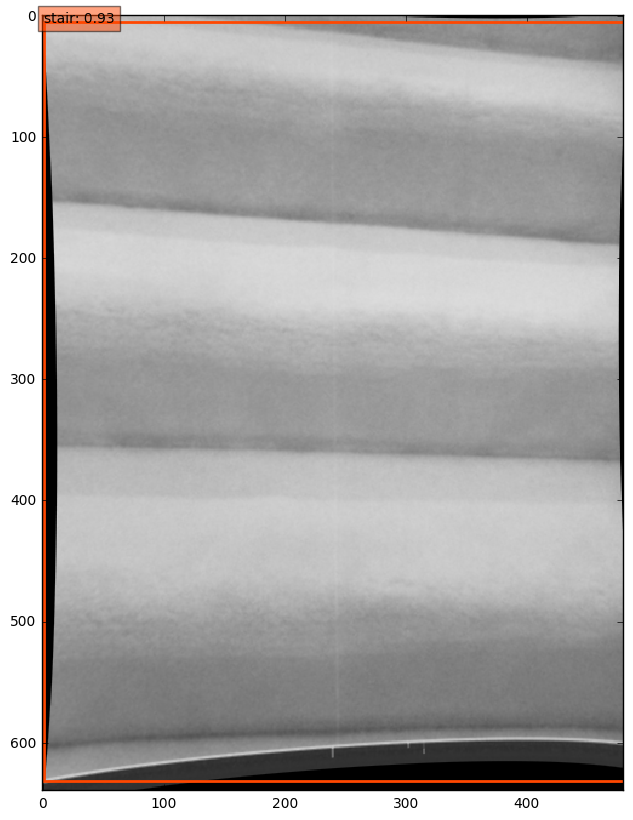

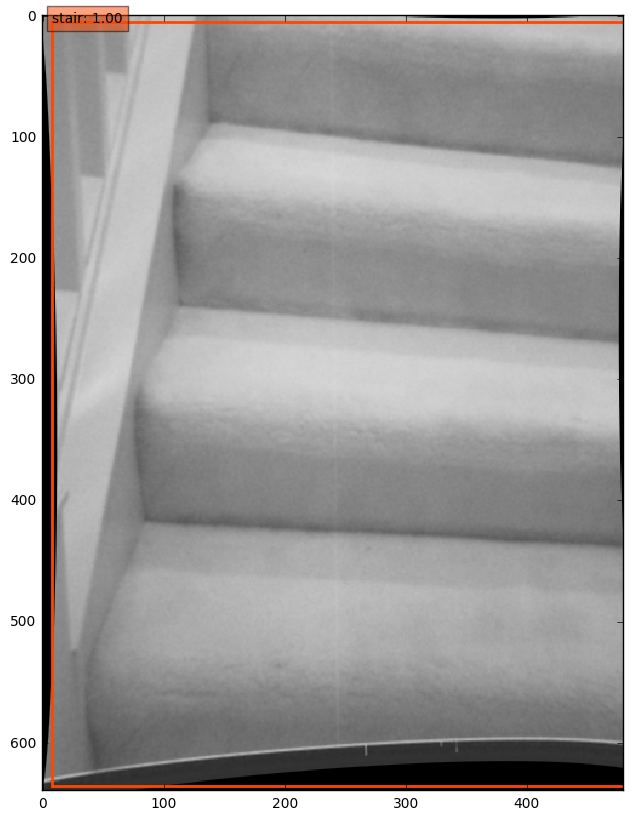

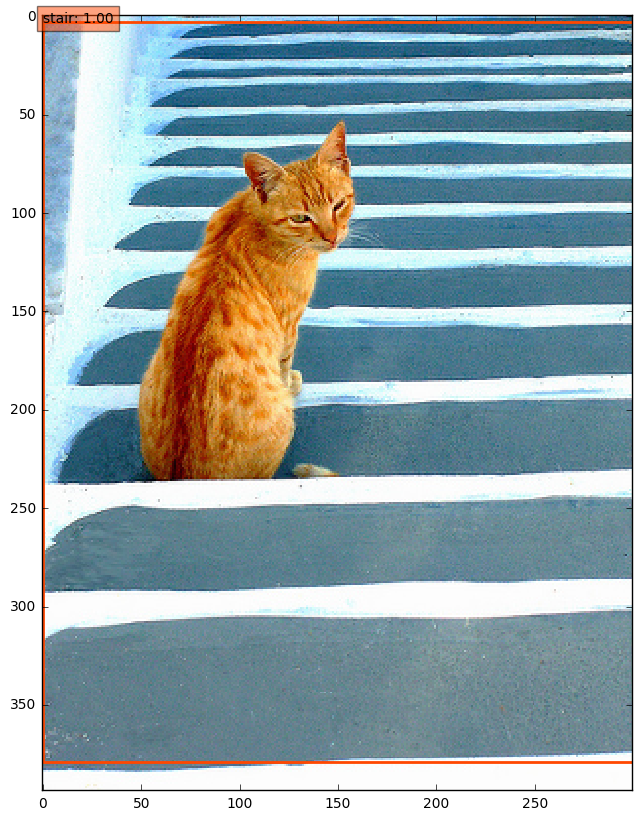

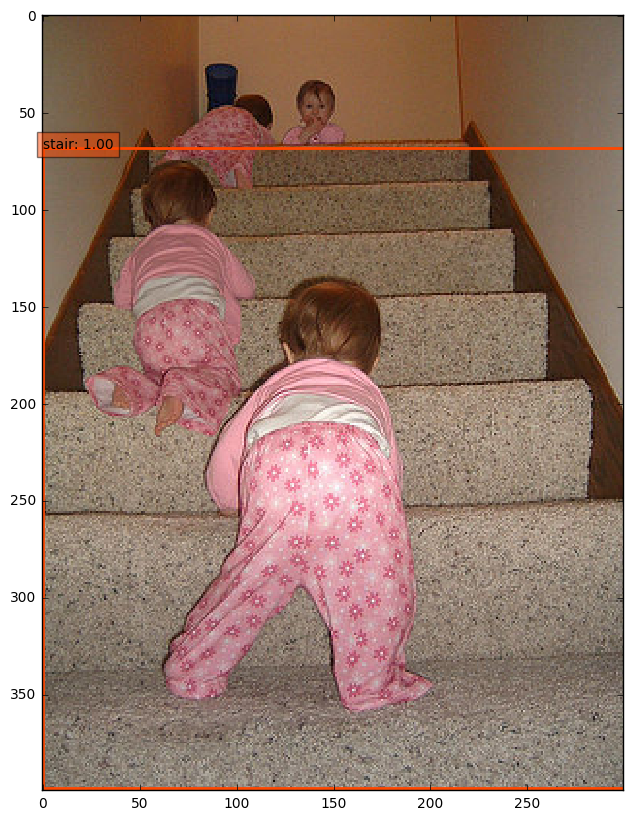

In [11]:
# set net to batch size of 1
image_resize = imsize
net.blobs['data'].reshape(1,3,image_resize,image_resize)

#image = caffe.io.load_image('examples/images/fish-bike.jpg')
# Cat on a stair
#image = caffe.io.load_image('/IMAGESETS/DVIADetDB/augmented.full/1_stair/1_stair_00137_00_BASE_IMAGE.png')
# Child on a stair
#image = caffe.io.load_image('/IMAGESETS/DVIADetDB/augmented.full/1_stair/1_stair_00199_00_BASE_IMAGE.png')
#image = caffe.io.load_image('/IMAGESETS/DVIADetDB/augmented.full/1_stair/1_stair_00399_00_BASE_IMAGE.png')
#plt.imshow(image)

im_path = "/home/maheriya/Projects/py-faster-rcnn/data/demo/"
im_names = ['1_stair_001.jpg', '1_stair_002.png', '2_curb_001.jpg', '2_curb_002.jpg',
            '3_doorframe_001.jpg', '3_doorframe_002.png', 
            '00120_00_BASE_IMAGE.png', '1_stair_00589_00_BASE_IMAGE.png',
            '2_curb_00101_00_BASE_IMAGE.png', '2_curb_00570_00_BASE_IMAGE.png', '2_curb_00503_00_BASE_IMAGE.png',
            'mono_imgl_3.png', 'mono_imgl_4.png', 'mono_imgl_5.png',
           'stair-with-cat.png', 'stair-with-child.png']



def show_detections(image, fig=1, DEBUG=False):
    ## Run the net and examine the top_k results
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image

    # Forward pass.
    detections = net.forward()['detection_out']

    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    if DEBUG:
        print "det_conf: {}".format(det_conf)
        #print "det_label: {}".format(det_label)
        det_labels = get_labelname(labelmap, [i for i in det_label])
        print "det_label: {}".format(det_labels)
    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    if DEBUG:
        print "top_indices: {}".format(top_indices)
        print "top_conf: {}".format(top_conf)
        #print "top_label_indices: {}".format(top_label_indices)
        print "top label: {}".format(top_labels)
    ## Plot the boxes
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.figure(fig)
    plt.imshow(image)
    currentAxis = plt.gca()

    for i in xrange(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

#

#image = caffe.io.load_image(os.path.join(im_path, im_names[0]))
fig = 1
for img in im_names:
    image = caffe.io.load_image(os.path.join(im_path, img))
    show_detections(image, fig)
    fig += 1